In [1]:
import numpy as np
import datetime
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets import interact

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F

C:\Users\moham\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [3]:
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT).to(device=device)
model.eval()


preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

"""
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
])
"""

'\npreprocess = transforms.Compose([\n    transforms.Resize(299),\n    transforms.CenterCrop(299),\n    transforms.ToTensor(),\n])\n'

In [4]:
image_paths = glob.glob("images\*")
images = []
preprocessed_images = []
labels = [294,292]
for path in image_paths:
    print(path)
    image = Image.open(path)
    preprocessed_image = preprocess(image).unsqueeze(0).to(device=device)
    
    images.append(image)
    preprocessed_images.append(preprocessed_image)

images\bald_eagle.jpg
images\boa_constrictor.jpg
images\box_turtle.jpg
images\brown_bear.jpg
images\cock.jpg
images\Samoyed.jpg
images\spotted_salamander.jpg
images\starfish.jpg
images\tiger.jpg
images\tiger_shark.jpg


In [5]:
for i in range(len(preprocessed_images)):
    image_gpu = preprocessed_images[i].to(device=device)

    with torch.no_grad():
        output = model(image_gpu)
    # Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
    #print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    arg = probabilities.argmax()
    print(arg)
    print(probabilities[arg].item())



tensor(22, device='cuda:0')
0.9023818969726562
tensor(61, device='cuda:0')
0.9911372661590576
tensor(37, device='cuda:0')
0.9482685923576355
tensor(294, device='cuda:0')
0.9613251686096191
tensor(7, device='cuda:0')
0.7233016490936279
tensor(258, device='cuda:0')
0.8836224675178528
tensor(28, device='cuda:0')
0.9221763014793396
tensor(327, device='cuda:0')
0.9993489384651184
tensor(292, device='cuda:0')
0.8158342242240906
tensor(3, device='cuda:0')
0.9781191349029541


In [6]:
def manual_single_epoch(model,img,label,epsilon,device,patch_small,patch_corner,target,clamp=True,clamp_range=[0.0,1.0]):
    
    revert_train = False
    if model.training:
        revert_train = True
        model.eval()
        
    patch_size = patch_small.shape[2]
    
    if patch_corner[0] + patch_size > img.shape[2] or patch_corner[1] + patch_size > img.shape[2]:
        raise Exception("Patch exceeds the borders of the image")
    
    model = model.to(device=device)
    
    x = img.to(device=device)
    x.requires_grad = False

    label_list = [label]
    label_t = torch.tensor(label_list).to(device=device)
        
    h_bottom = patch_corner[0]
    h_top = h_bottom + patch_size
    
    w_left = patch_corner[0]
    w_right = w_left + patch_size
    
    n, c, h, w = x.shape
    
    patch = torch.zeros(x.shape)
    mask = torch.zeros(x.shape)
        
    mask[:, :, h_bottom: h_top , w_left:w_right] = 1
    
    patch[:, : , h_bottom:h_top , w_left:w_right ] = patch_small
    
    patch = patch.to(device=device)
    mask = mask.to(device=device)
    
    adv_x = torch.mul((1-mask),x) + torch.mul(mask,patch)
    
    target_list = [target]
    target_t = torch.tensor(target_list).to(device=device)


    adv_x.requires_grad = True

    output = model(adv_x)
            
            
    loss = F.cross_entropy(output, target_t) - F.cross_entropy(output, label_t)
    loss.backward()

    adv_grad = adv_x.grad.clone()
    adv_x.grad.data.zero_()

    patch -= adv_grad * epsilon


    if clamp:
        #adv_x = torch.clamp(adv_x, clamp_range[0], clamp_range[1])
        patch = torch.clamp(patch, clamp_range[0], clamp_range[1])
                
                
    if revert_train:
        model.train()
    
    return loss.item(), patch[:,:,h_bottom:h_bottom+patch_size,w_left:w_left +patch_size]

In [7]:
patch_size = 50
patch_small = np.random.uniform(0.0, 1.0, (1, 3, patch_size, patch_size))
patch_small = torch.from_numpy(patch_small)
label = torch.tensor([294])

In [10]:
label_list = [22,61,37,294,7,258,28,327,292,3]
#labels = []
#for i in range(len(labels_list)):
#    labels.append(torch.tensor([labels_list[i]]))

In [12]:
epochs = 300
epsilon = 0.5
clamp_range = [-2,2]
target = 855


for i in range(epochs):
    loss_cum = 0
    for j in range(len(preprocessed_images)):
        xcorner = np.random.randint(0,299-patch_size-1)
        ycorner = np.random.randint(0,299-patch_size-1)
        corner_cords = [xcorner,ycorner]
        loss, patch_small = manual_single_epoch(model,preprocessed_images[j],label_list[j],epsilon,device,patch_small,\
        corner_cords,target,clamp=True,clamp_range=clamp_range)
        loss_cum += loss
        
    if (i+1)%(epochs//10) == 0: 
        avg_loss = loss_cum/len(preprocessed_images)
        print("Average loss at epoch {}: {:04f}".format(i+1,avg_loss))

Average loss at epoch 100: -14.349076
Average loss at epoch 200: -12.947602
Average loss at epoch 300: -13.318799


In [24]:
def apply_evaluate_patch(patch_small,model,img,patch_corner):

    revert_train = False
    if model.training:
        revert_train = True
        model.eval()
        
    patch_size = patch_small.shape[2]
    
    if patch_corner[0] + patch_size > img.shape[2] or patch_corner[1] + patch_size > img.shape[2]:
        raise Exception("Patch exceeds the borders of the image")
    
    model = model.to(device=device)
    
    x = img.to(device=device)
    x.requires_grad = False

    label_list = [label]
    label_t = torch.tensor(label_list).to(device=device)
        
    h_bottom = patch_corner[0]
    h_top = h_bottom + patch_size
    
    w_left = patch_corner[0]
    w_right = w_left + patch_size
    
    n, c, h, w = x.shape
    
    patch = torch.zeros(x.shape)
    mask = torch.zeros(x.shape)
        
    mask[:, :, h_bottom: h_top , w_left:w_right] = 1
    
    patch[:, : , h_bottom:h_top , w_left:w_right ] = patch_small
    
    patch = patch.to(device=device)
    mask = mask.to(device=device)
    
    adv_x = torch.mul((1-mask),x) + torch.mul(mask,patch)
    
    target_list = [target]
    target_t = torch.tensor(target_list).to(device=device)

    adv_x.requires_grad = False

    output = model(adv_x)

    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities

In [20]:
for i in range(10):
    result = apply_evaluate_patch(patch_small,model,preprocessed_images[i],[30,30])
    probabilities = torch.nn.functional.softmax(result[0], dim=0)
    arg = probabilities.argmax()
    print(arg)
    print(probabilities[arg].item())

tensor(855, device='cuda:0')
0.9994193315505981
tensor(855, device='cuda:0')
0.9991175532341003
tensor(855, device='cuda:0')
0.9994131326675415
tensor(855, device='cuda:0')
0.998608410358429
tensor(855, device='cuda:0')
0.9979933500289917
tensor(855, device='cuda:0')
0.9997833371162415
tensor(855, device='cuda:0')
0.9923812747001648
tensor(855, device='cuda:0')
0.9981037378311157
tensor(855, device='cuda:0')
0.9907178282737732
tensor(855, device='cuda:0')
0.9995423555374146


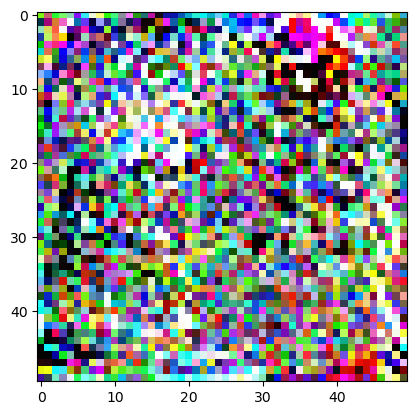

In [24]:
transform = transforms.ToPILImage()
img_test = transform(patch_small[0])
plt.imshow(img_test)

In [20]:
image_gpu = preprocessed_images[0].to(device=device)

with torch.no_grad():
    output = model(image_gpu)
# Tensor of shape 1000, with confidence scores over ImageNet's 1000 classes
#print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [21]:
arg = probabilities.argmax()
print(arg)
print(probabilities[arg].item())

tensor(22, device='cuda:0')
0.9023818969726562
